In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [52]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
#LPV ## Check columns info
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
session.query(func.max(Measurement.date)).all()

[('2017-08-23')]

In [13]:
#LPV ## Verifing the max value
session.query(Measurement.id, Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= "2017-08-23").\
    all()

[(2724, 'USC00519397', '2017-08-23', 0.0, 81.0),
 (7635, 'USC00514830', '2017-08-23', 0.0, 82.0),
 (12187, 'USC00519523', '2017-08-23', 0.08, 82.0),
 (19550, 'USC00516128', '2017-08-23', 0.45, 76.0)]

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.
# Calculate the date one year from the last date in data set.
last_date = dt.date(2017, 8, 23)
twelve_months = relativedelta(months=12)
one_year_ago_date = last_date - twelve_months
one_year_ago_date

datetime.date(2016, 8, 23)

In [15]:
# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
              filter(Measurement.date >= one_year_ago_date).\
              all()

#for record in results:
#    (ms) = record
#    print(f"{ms.date},{ms.prcp}")

# Save the query results as a Pandas DataFrame and set the index to the date column
ms_rows = [{"Date":result[0], "PRCP":result[1]} for result in results]
ms_df = pd.DataFrame(ms_rows).set_index("Date")

# Sort the dataframe by date
ms_df.sort_values("Date", inplace=True)

In [16]:
results

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0),
 ('2016-09-02', 0.0),
 ('2016-09-03', 0.0),
 ('2016-09-04', 0.03),
 ('2016-09-05', None),
 ('2016-09-06', None),
 ('2016-09-07', 0.05),
 ('2016-09-08', 0.0),
 ('2016-09-09', 0.03),
 ('2016-09-10', 0.0),
 ('2016-09-11', 0.05),
 ('2016-09-12', 0.0),
 ('2016-09-13', 0.02),
 ('2016-09-14', 1.32),
 ('2016-09-15', 0.42),
 ('2016-09-16', 0.06),
 ('2016-09-17', 0.05),
 ('2016-09-18', 0.0),
 ('2016-09-19', 0.0),
 ('2016-09-20', 0.0),
 ('2016-09-21', 0.0),
 ('2016-09-22', 0.02),
 ('2016-09-23', 0.0),
 ('2016-09-24', 0.0),
 ('2016-09-25', 0.0),
 ('2016-09-26', 0.06),
 ('2016-09-27', 0.02),
 ('2016-09-28', 0.0),
 ('2016-09-29', 0.0),
 ('2016-09-30', 0.0),
 ('2016-10-01', 0.0),
 ('2016-10-02', 0.0),
 ('2016-10-03', 0.0),
 ('2016-10-04', 0.0),
 ('2016-10-05', 0.0),
 ('2016-10-06'

In [17]:
ms_df.head()

,PRCP
Date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


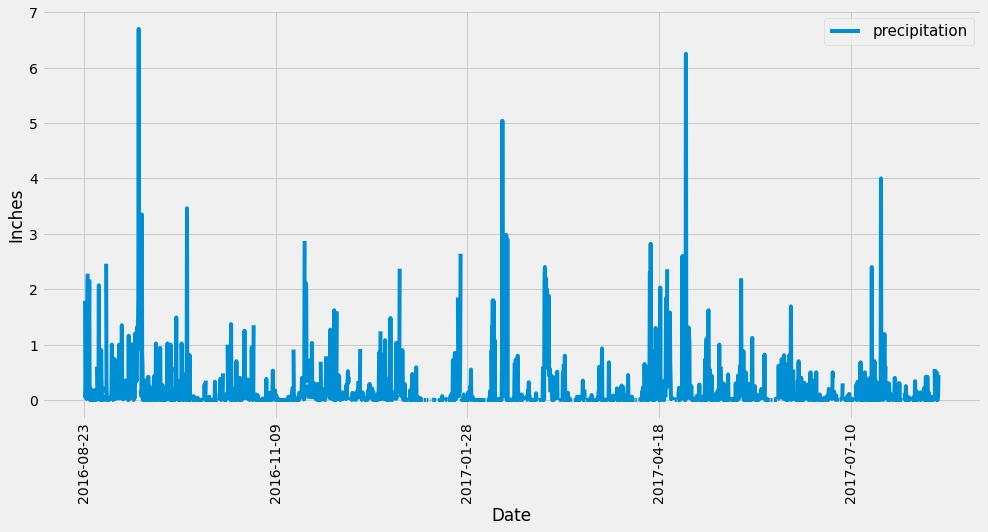

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
ms_df.plot(kind="line", figsize=(15,7), rot="vertical", grid=True)
plt.legend(labels=["precipitation"], prop={'size': 15}, bbox_to_anchor=(1, 1))
plt.xlabel("Date")
plt.ylabel("Inches")
plt.show()

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
ms_df.describe()

,PRCP
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [20]:
# Design a query to calculate the total number stations in the dataset
session.query(Station).count()

9

In [21]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.station).desc()).\
        all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [Measurement.station, 
       func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]

session.query(*sel).filter(Measurement.station == "USC00519281").\
                   group_by(Measurement.station).\
                   all()


[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [44]:
session.query(func.max(Measurement.date)).\
    filter(Measurement.station == "USC00519281").\
    all()

[('2017-08-18')]

In [24]:
last_date = dt.date(2017, 8, 18)
twelve_months = relativedelta(months=12)
one_year_ago_date = last_date - twelve_months
one_year_ago_date

datetime.date(2016, 8, 18)

In [25]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_result = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == "USC00519281").\
    filter(Measurement.date >= one_year_ago_date).\
    all()

In [26]:
tobs_rows = [{"Date":result[0], "TOBS":result[1]} for result in tobs_result]
tobs_df = pd.DataFrame(tobs_rows)
len(tobs_df)

357

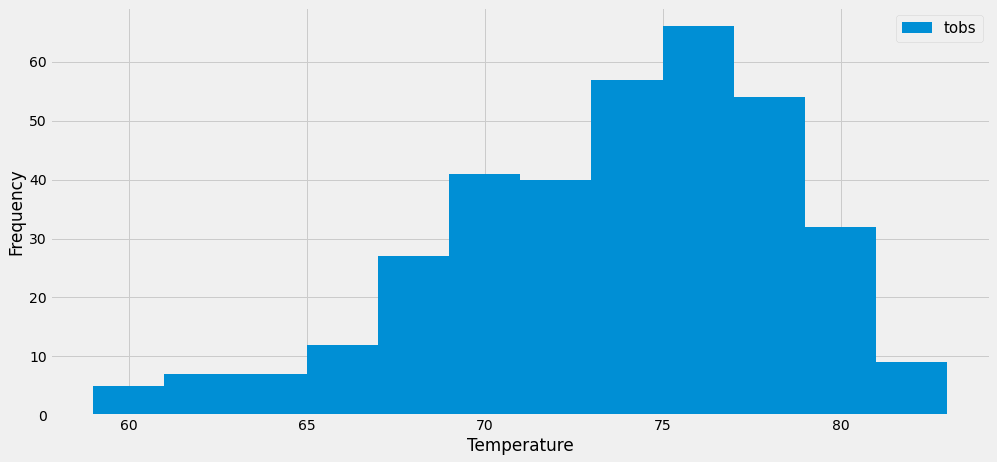

In [27]:
x= tobs_df["TOBS"]
plt.figure(figsize=(15, 7))
plt.hist(x, bins = 12)
plt.legend(labels=["tobs"], prop={'size': 15}, bbox_to_anchor=(1, 1))
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

# Close session

In [28]:
# Close Session
session.close()